G328.25 13181427.882952059 Jy / sr 45513883.62992256 Jy / sr
G333.60 16178339.251008224 Jy / sr 14103049.004428385 Jy / sr
G012.80 4998803.53855611 Jy / sr 17130561.282274507 Jy / sr
W51-IRS2 30999510.361605294 Jy / sr 15697765.602697382 Jy / sr
G008.67 19662620.51594486 Jy / sr 31404711.47833175 Jy / sr
G327.29 31029031.936980177 Jy / sr 31008156.89774362 Jy / sr
G010.62 17084959.40323771 Jy / sr 14806241.306256719 Jy / sr
G337.92 15244221.275432114 Jy / sr 27819512.445585873 Jy / sr
G338.93 15037593.969443426 Jy / sr 22589558.989696436 Jy / sr
G351.77 4825858.360417986 Jy / sr 26352791.8620449 Jy / sr
G353.41 4060526.4931065375 Jy / sr 19520720.65761169 Jy / sr
W43-MM3 9705935.483966723 Jy / sr 11387643.767406534 Jy / sr
W43-MM2 18661563.050203223 Jy / sr 20918094.00498428 Jy / sr
W51-E 30289035.51767966 Jy / sr 78467914.42659266 Jy / sr


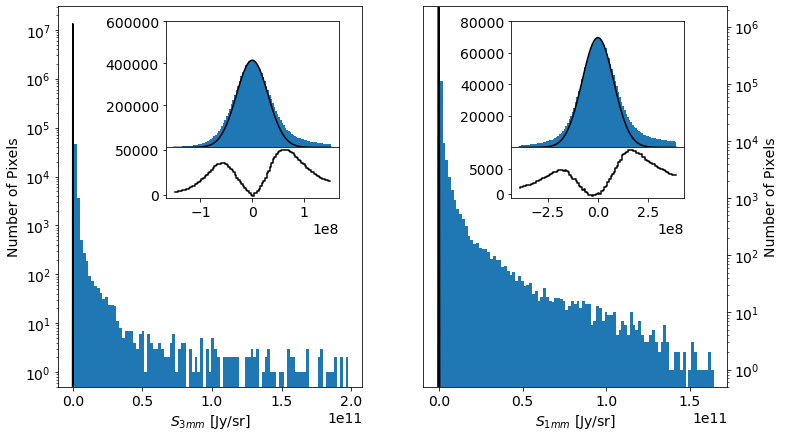

In [1]:
%run ../analysis/histograms.py

In [2]:
pfxs = prefixes['G12']
pfxs

{'finaliter_prefix_b3': 'G012.80/B3/cleanest/G012.80_B3_uid___A001_X1296_X1fb_continuum_merged_12M_robust0_selfcal7_finaliter',
 'finaliter_prefix_b6': 'G012.80/B6/cleanest/G012.80_B6_uid___A001_X1296_X1ef_continuum_merged_12M_robust0_selfcal6_finaliter'}

G012.80 4998803.53855611 Jy / sr 17130561.282274507 Jy / sr


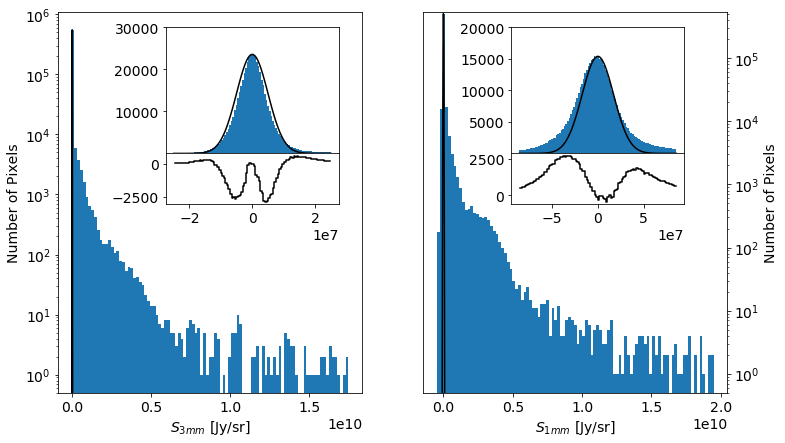

In [3]:
flux_hist(basepath=basepath, **pfxs)

In [4]:
finaliter_prefix_b3 = pfxs['finaliter_prefix_b3']
finaliter_prefix_b6 = pfxs['finaliter_prefix_b6']

In [5]:
las=False

G012.80 4998803.53855611 Jy / sr 17130561.282274507 Jy / sr


(-94218087.0525098, 94218087.0525098)

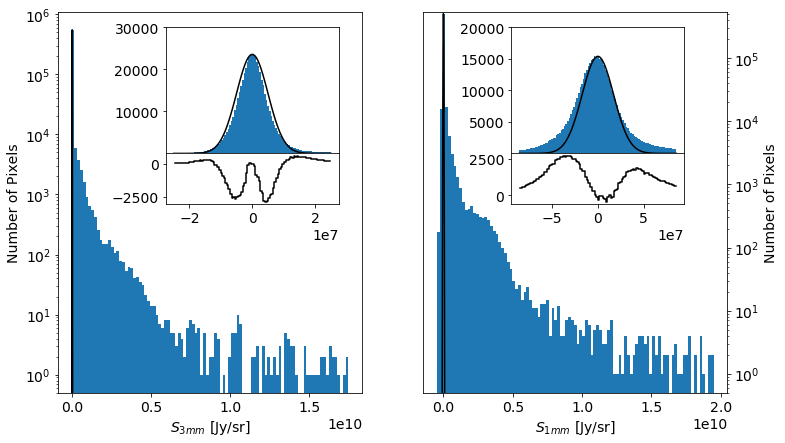

In [6]:
    image_b3 = SpectralCube.read(f'{finaliter_prefix_b3}.image.tt0.fits', use_dask=False, format='fits').minimal_subcube()
    image_b6 = SpectralCube.read(f'{finaliter_prefix_b6}.image.tt0.fits', use_dask=False, format='fits').minimal_subcube()
    image_b3 = image_b3 * u.beam / image_b3.beam.sr
    image_b6 = image_b6 * u.beam / image_b6.beam.sr

    fieldname = os.path.basename(finaliter_prefix_b6).split("_")[0]

    if las:
        smb3 = image_b3[0].convolve_to(radio_beam.Beam(las), allow_huge=True)
        image_b3 = image_b3 - smb3
        smb6 = image_b6[0].convolve_to(radio_beam.Beam(las), allow_huge=True)
        image_b6 = image_b6 - smb6

    noise_region_b3 = regions.read_ds9(f"{basepath}/reduction/noise_estimation_regions/{fieldname}_B3_noise_sampling.reg")
    noise_region_b6 = regions.read_ds9(f"{basepath}/reduction/noise_estimation_regions/{fieldname}_B6_noise_sampling.reg")

    noiseim_b3 = image_b3.subcube_from_regions(noise_region_b3)[0]
    noiseim_b6 = image_b6.subcube_from_regions(noise_region_b6)[0]

    b3_std = stats.mad_std(noiseim_b3, ignore_nan=True)
    b6_std = stats.mad_std(noiseim_b6, ignore_nan=True)
    print(fieldname, b3_std, b6_std)

    fig = pl.figure(2, figsize=(12,7))
    fig.clf()
    ax = pl.subplot(1,2,1)
    b3data = image_b3[0].value
    bins_b3 = np.linspace(np.nanmin(b3data), np.nanmax(b3data), 100)
    bins_b3b = np.linspace(np.nanmin(b3data), np.nanmax(b3data), 10000)
    H,L,P = ax.hist(b3data[np.isfinite(b3data)], bins=bins_b3, density=False)
    #ax.hist(noiseim_b3.value.ravel(), bins=bins_b3)
    ax.set_yscale('log')
    ax.set_ylim(0.5, ax.get_ylim()[1])
    ax.plot(bins_b3b, H.max() * np.exp(-bins_b3b**2/(2*b3_std.value**2)), 'k')
    ax.set_xlabel("$S_{3mm}$ [Jy/sr]")
    ax.set_ylabel("Number of Pixels")

    axin = fig.add_axes([0.25, 0.6, 0.20, 0.25])
    bins = np.linspace(-5*b3_std.value, 5*b3_std.value, 100)
    H,L,P = axin.hist(b3data[(b3data < 5*b3_std.value) & (b3data > -5*b3_std.value)], bins=bins, density=False)
    #axin.hist(noiseim_b3.value.ravel(), bins=bins)
    gauss = H.max() * np.exp(-bins**2/(2*b3_std.value**2))
    axin.plot(bins, gauss, 'k')
    axin.set_xticklabels([])
    axin.set_yticks(axin.get_yticks()[1:])
    axin2 = fig.add_axes([0.25, 0.5, 0.2, 0.1])
    loc = (L[1:] + L[:-1])/2
    axin2.plot(loc, H-H.max() * np.exp(-loc**2/(2*b3_std.value**2)), drawstyle='steps', color='k')
    axin2.set_xlim(axin.get_xlim())

    ax = pl.subplot(1,2,2)
    b6data = image_b6[0].value
    bins_b6 = np.linspace(np.nanmin(b6data), np.nanmax(b6data), 100)
    bins_b6b = np.linspace(np.nanmin(b6data), np.nanmax(b6data), 10000)
    H,L,P = ax.hist(b6data[np.isfinite(b6data)], bins=bins_b6, density=False)
    ax.plot(bins_b6b, H.max() * np.exp(-bins_b6b**2/(2*b6_std.value**2)), 'k')
    #ax.hist(noiseim_b6.value.ravel(), bins=bins_b6)
    ax.set_ylim(0.5, ax.get_ylim()[1])
    ax.set_yscale('log')
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.set_xlabel("$S_{1mm}$ [Jy/sr]")
    ax.set_ylabel("Number of Pixels")

    axin = fig.add_axes([0.65, 0.6, 0.20, 0.25])
    bins = np.linspace(-5*b6_std.value, 5*b6_std.value, 100)
    H,L,P = axin.hist(b6data[(b6data < 5*b6_std.value) & (b6data > -5*b6_std.value)], bins=bins, density=False)
    #axin.hist(noiseim_b6.value.ravel(), bins=bins)
    axin.plot(bins, H.max() * np.exp(-bins**2/(2*b6_std.value**2)), 'k')
    axin.set_xticklabels([])
    axin.set_yticks(axin.get_yticks()[1:])
    axin2 = fig.add_axes([0.65, 0.5, 0.2, 0.1])
    loc = (L[1:] + L[:-1])/2
    axin2.plot(loc, H-H.max() * np.exp(-loc**2/(2*b6_std.value**2)), drawstyle='steps', color='k')
    axin2.set_xlim(axin.get_xlim())

INFO: Auto-setting vmin to -5.804e+07 [aplpy.core]
INFO: Auto-setting vmax to  6.548e+07 [aplpy.core]


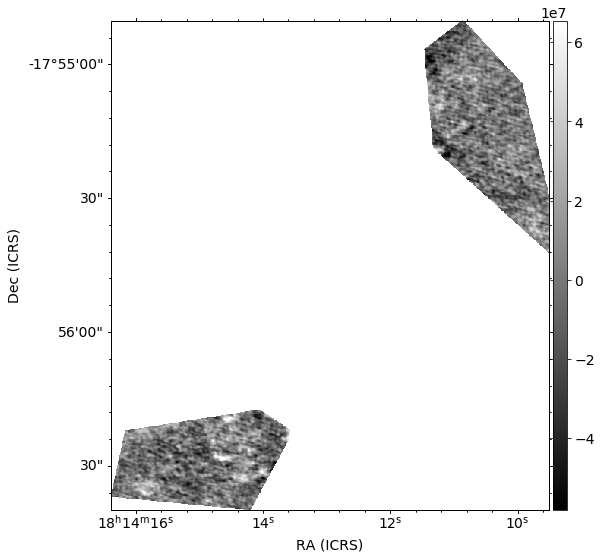

In [7]:
noiseim_b6.quicklook()